In [1]:
import numpy as np
import math
import pandas as pd
import datetime as dt
import os
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
%matplotlib inline 


Data import and add days together

In [16]:
df=pd.read_excel("D:\\360MoveData\\Users\\historia\\Desktop\\MEng\\nutVal.xlsx",sheet_name="combination",dtype="object", names = ['Dates', 'Quantity', 'Pounds', 'value','Nutrition category'])
df['Dates'] = pd.to_datetime(df['Dates'])
df = df.set_index('Dates')
s = pd.Series(df['Pounds'], index=df.index )
s = s.resample('w').sum()
s.drop(s[s == False].index, inplace=True)
df1 = pd.DataFrame({'Dates':s.index, 'Pounds':s.values})
print(df1.head(5))
print(df1.shape)
#print(df1['Dates'][100])


       Dates   Pounds
0 2016-01-10  13340.0
1 2016-01-17  15287.0
2 2016-01-24  19168.0
3 2016-01-31  20153.0
4 2016-02-07  25672.0
(123, 2)


In [3]:
#Other way to import data copied from my SVR code, they may not be so useful but I put it here.
# print(df1)
# m=[]
# n=[]
# for i in range(len(df1['Dates'])):
#     m.append(i)
#     n.append(df1['Quantity'][i])
# m=np.array(m).reshape(-1,len(m)).T
# a=input('Input the train weeks:')
# b=input('Input the test weeks:')
# TRAIN_SIZE=int(a)
# TEST_SIZE=int(b)
#data = pd.read_csv('D:\\360MoveData\\Users\\historia\\Desktop\\Dessert.csv')

Smoothing and normalize the data

In [21]:
#### Store the quantity data in a variable
Quantity_Supply = df1.loc[:, 'Pounds'].values.astype(float)
a=input('Input the train days:')
TRAIN_SIZE=int(a)
FULL_SIZE=int(input('Input the full size of the data:'))
TEST_SIZE=FULL_SIZE-TRAIN_SIZE
######################### if use other types the test size will change ########################################  

# Split the data into testing data and training data
train_data = Quantity_Supply[:TRAIN_SIZE]
test_data = Quantity_Supply[TRAIN_SIZE:]

##Normalizing the Data
#Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Train the Scaler with training data and smooth data
# smoothing_window_size = int(120)
# for i in range(0,240,smoothing_window_size):
#     scaler.fit(train_data[i:i+smoothing_window_size,:])
#     train_data[i:i+smoothing_window_size,:] = scaler.transform(train_data[i:i+smoothing_window_size,:])
smoothing_window_size = int(35)
for i in range(0,70,smoothing_window_size):
    scaler.fit(train_data[i:i+smoothing_window_size,:])
    train_data[i:i+smoothing_window_size,:] = scaler.transform(train_data[i:i+smoothing_window_size,:])

# You normalize the last bit of remaining data
print(train_data[i+smoothing_window_size:,:])
scaler.fit(train_data[i+smoothing_window_size:,:])
train_data[i+smoothing_window_size:,:] = scaler.transform(train_data[i+smoothing_window_size:,:])

# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)
all_quant_data = np.concatenate([train_data,test_data],axis=0)
#Now perform exponential moving average smoothing
#So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(FULL_SIZE):
  EMA = gamma*all_quant_data[ti] + (1-gamma)*EMA
  all_quant_data[ti] = EMA
train_data = all_quant_data[:TRAIN_SIZE]
test_data = all_quant_data[TRAIN_SIZE:]
# EMA = 0.0
# gamma = 0.1
# for ti in range(TRAIN_SIZE):
#   EMA = gamma*train_data[ti] + (1-gamma)*EMA
#   train_data[ti] = EMA
# # So the data will have a smoother curve than the original ragged data
# EMA = 0.0
# gamma = 0.1
# for ti in range(FULL_SIZE-TRAIN_SIZE):
#   EMA = gamma*test_data[ti] + (1-gamma)*EMA
#   test_data[ti] = EMA

Input the train days:100
Input the full size of the data:123
[[ 7774. ]
 [17985. ]
 [10348. ]
 [20948. ]
 [12292. ]
 [16467. ]
 [34021. ]
 [19471. ]
 [20506. ]
 [15767. ]
 [28429. ]
 [ 4841. ]
 [33521. ]
 [14230.5]
 [24173. ]
 [ 9828. ]
 [18460. ]
 [ 8968. ]
 [58211. ]
 [ 9370. ]
 [32369. ]
 [12260. ]
 [ 5469. ]
 [ 9552. ]
 [26206. ]
 [28673. ]
 [12850. ]
 [35927. ]
 [15312. ]
 [12147. ]]


Decompose and plot the picture of decomposing (If needed)

In [19]:
print(len(test_data[6:]))
# data.index=pd.DatetimeIndex(freq='d',start=0,periods=576)
# result = seasonal_decompose(data, model='additive')
# # Decomposing
# decomp = sm.tsa.seasonal_decompose(data)
# decomp.plot()
# plt.show()

17


Using polynomial linear regression

In [25]:
from sklearn.preprocessing import PolynomialFeatures 
b=int(input('Input the Polynomial features:'))
polynomial_features= PolynomialFeatures(degree=b)
x = np.array(range(1,TRAIN_SIZE+1))
x = x.reshape(TRAIN_SIZE,-1)
x_t = np.array(range(TRAIN_SIZE+1,FULL_SIZE+1))
x_t = x_t.reshape(TEST_SIZE,1)
x_poly = polynomial_features.fit_transform(x)
lr = LinearRegression()
lr.fit(x_poly, train_data)
#pred_test=lr.predict(polynomial_features.fit_transform(x_t))
pred_test=lr.fit(x_poly, train_data).predict(polynomial_features.fit_transform(x_t))
pred_train=lr.fit(x_poly, train_data).predict(polynomial_features.fit_transform(x))
#Full data size is 570 and if change the testing data to each type this 576 will have to be changed.

#print(pred_test)

Input the Polynomial features:5


Calculate the MSE and SMSE

In [26]:
mse=mean_squared_error(test_data, pred_test)
smse=np.sqrt(mean_squared_error(test_data, pred_test))
print('The MSE is',mse,'The smse is',smse)

The MSE is 0.14043405823329122 The smse is 0.37474532449824005


Draw the plot

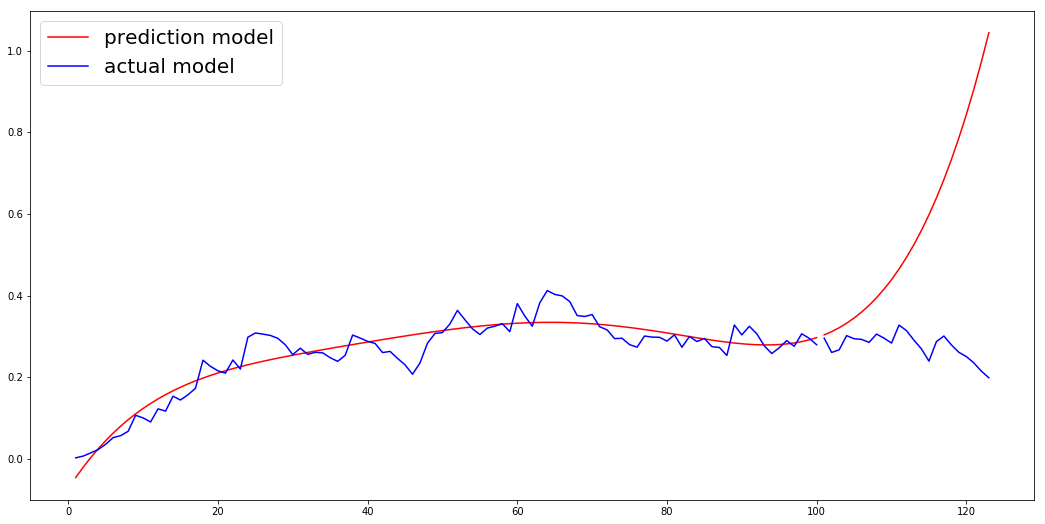

In [27]:
plt.figure(figsize = (18,9))
plt.plot([x for x in range(TRAIN_SIZE+1,TRAIN_SIZE+TEST_SIZE+1)], pred_test, linestyle='-', color='red', label='prediction model')  
plt.plot([x for x in range(1,TRAIN_SIZE+1)], pred_train, linestyle='-', color='red')
plt.plot(x,train_data, linestyle='-', color='blue', label='actual model')
plt.plot(x_t,test_data, linestyle='-', color='blue')
# plt.plot(x_c,y_c, linestyle='-', color='blue')
#plt.xlim(470,570)

plt.legend(loc='best', prop={'size':20})
plt.show()

Calculate the time of processing

In [9]:
start = time.clock()
end = time.clock()
run_time = end - start
rt=run_time
print('The processing time of the model is: ',rt)

The processing time of the model is:  0.00016149999999015563


D:\work\Anaconda\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.
D:\work\Anaconda\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
